In [ ]:
# Cell 1: Setup & Imports
!pip install tqdm
!pip install nltk
import nltk
nltk.download("punkt")
import os, re, json, random,math
import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import numpy as np
import random
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
import Levenshtein
from tqdm import tqdm
import matplotlib.pyplot as plt
import requests, zipfile, io

print("[INFO] Libraries loaded successfully.")


[INFO] Libraries loaded successfully.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Cell 2: Load aligned Urdu–Roman pairs from all poet folders
from google.colab import drive
if not os.path.exists("/content/drive"):
    drive.mount("/content/drive", force_remount=True)
else:
    print("[INFO] Google Drive already mounted.")
base_dir = "/content/drive/MyDrive/Colab Notebooks/training_dataset/dataset/dataset (1)"

urdu_texts, roman_texts = [], []

# Loop over each poet folder
for poet in os.listdir(base_dir):
    poet_path = os.path.join(base_dir, poet)
    if not os.path.isdir(poet_path):
        continue

    ur_dir = os.path.join(poet_path, "ur")
    en_dir = os.path.join(poet_path, "en")

    if not os.path.exists(ur_dir) or not os.path.exists(en_dir):
        print(f"[WARN] Skipping {poet}, missing ur/en folders.")
        continue

    # Loop over Urdu files and find matching Roman files
    for fname in sorted(os.listdir(ur_dir)):
        ur_path = os.path.join(ur_dir, fname)
        en_path = os.path.join(en_dir, fname)

        if not os.path.exists(en_path):
            print(f"[WARN] Skipping {poet}/{fname}, Roman file missing.")
            continue

        with open(ur_path, "r", encoding="utf-8", errors="ignore") as f1, \
             open(en_path, "r", encoding="utf-8", errors="ignore") as f2:
            ur = f1.read().strip()
            en = f2.read().strip()
            if ur and en:  # skip empty
                urdu_texts.append(ur)
                roman_texts.append(en)

print(f"[INFO] Loaded {len(urdu_texts)} aligned Urdu–Roman pairs from {len(os.listdir(base_dir))} poet folders.")
if urdu_texts:
    print("[DEBUG] Sample Urdu:", urdu_texts[0][:120])
    print("[DEBUG] Sample Roman:", roman_texts[0][:120])


[INFO] Google Drive already mounted.
[INFO] Loaded 1314 aligned Urdu–Roman pairs from 31 poet folders.
[DEBUG] Sample Urdu: زحال مسکیں مکن تغافل دورائے نیناں بنائے بتیاں 
کہ تاب ہجراں ندارم اے جاں نہ لیہو کاہے لگائے چھتیاں 
شبان ہجراں دراز چوں 
[DEBUG] Sample Roman: ze-hāl-e-miskīñ makun taġhāful durā.e naināñ banā.e batiyāñ 
ki tāb-e-hijrāñ nadāram ai jaañ na lehū kaahe lagā.e chhati


In [ ]:
# Cell 3: Urdu normalization functions with debug prints
import re
import unicodedata

# class UrduTextProcessor:
#     def __init__(self):
#         self.urdu_chars = set('ابتپتٹثجچحخدڈذرڑزژسشصضطظعغفقکگلمنوہءیےؤئںآاؑٱ')
#         self.keep_punct = set(' .،؟!۔،،:;\'"–-—()؟')

#     def normalize_urdu(self, text: str) -> str:
#         if not text:
#             return ""
#         text = unicodedata.normalize('NFKC', text)
#         text = re.sub(r'[\r\n\t]+', ' ', text)
#         text = text.strip()
#         text = re.sub(r'[\u0610-\u061A\u064B-\u065F\u0670\u06D6-\u06ED]', '', text)
#         text = ' '.join(text.split())
#         cleaned = []
#         for ch in text:
#             if ch in self.urdu_chars or ch.isspace() or ch in self.keep_punct:
#                 cleaned.append(ch)
#         return ''.join(cleaned).strip()

# processor = UrduTextProcessor()
# urdu_texts = [processor.normalize_urdu(p['urdu']) for p in pairs]
# roman_texts = [p['roman'].strip().lower() for p in pairs]

# data = [(u,r) for u,r in zip(urdu_texts, roman_texts) if u and r]
# print(f"[INFO] After normalization: {len(data)} pairs")
# print("[DEBUG] Sample normalized pair:", data[0] if data else "None")
# Cell 3: Preprocessing + BPE
def normalize_urdu(text):
    text = re.sub(r"[^\u0600-\u06FF\s]", "", text)  # Urdu chars only
    return re.sub(r"\s+", " ", text).strip()

urdu_texts = [normalize_urdu(t) for t in urdu_texts]

class BPE:
    def __init__(self, num_merges=1000):
        self.num_merges = num_merges
        self.bpe_codes = {}

    def get_stats(self, corpus):
        pairs = {}
        for word, freq in corpus.items():
            symbols = word.split()
            for i in range(len(symbols)-1):
                pair = (symbols[i], symbols[i+1])
                pairs[pair] = pairs.get(pair, 0) + freq
        return pairs

    def merge_vocab(self, pair, v_in):
        v_out = {}
        bigram = ' '.join(pair)
        replacement = ''.join(pair)
        for word in v_in:
            new_word = re.sub(r'(?<!\S)' + bigram + r'(?!\S)', replacement, word)
            v_out[new_word] = v_in[word]
        return v_out

    def fit(self, texts):
        corpus = {}
        for word in texts:
            tokens = " ".join(list(word)) + " </w>"
            corpus[tokens] = corpus.get(tokens, 0) + 1
        for i in range(self.num_merges):
            pairs = self.get_stats(corpus)
            if not pairs: break
            best = max(pairs, key=pairs.get)
            corpus = self.merge_vocab(best, corpus)
            self.bpe_codes[best] = i

    def encode(self, word):
        word = list(word) + ["</w>"]
        while True:
            pairs = [(word[i], word[i+1]) for i in range(len(word)-1)]
            bigrams = {p: self.bpe_codes[p] for p in pairs if p in self.bpe_codes}
            if not bigrams: break
            best = min(bigrams, key=bigrams.get)
            i = pairs.index(best)
            word[i:i+2] = ["".join(best)]
        return word

bpe_src, bpe_tgt = BPE(500), BPE(500)
bpe_src.fit(urdu_texts)
bpe_tgt.fit(roman_texts)

print("[INFO] BPE trained.")
print("[DEBUG] Urdu encoding:", bpe_src.encode("محبت"))
print("[DEBUG] Roman encoding:", bpe_tgt.encode("mohabbat"))


[INFO] BPE trained.
[DEBUG] Urdu encoding: ['م', 'ح', 'ب', 'ت', '</w>']
[DEBUG] Roman encoding: ['m', 'o', 'ha', 'b', 'ba', 't', '</w>']


In [ ]:
# Cell 4: Build vocab + Dataset
SOS, EOS, PAD = "<s>", "</s>", "<pad>"

def build_vocab(texts, bpe):
    vocab = {PAD:0, SOS:1, EOS:2}
    for t in texts:
        for tok in bpe.encode(t):
            if tok not in vocab:
                vocab[tok] = len(vocab)
    return vocab

src_vocab = build_vocab(urdu_texts, bpe_src)
tgt_vocab = build_vocab(roman_texts, bpe_tgt)

print(f"[INFO] Vocab sizes: src={len(src_vocab)}, tgt={len(tgt_vocab)}")

class UrduRomanDataset(Dataset):
    def __init__(self, src, tgt, bpe_src, bpe_tgt, src_vocab, tgt_vocab):
        self.data = []
        for s, t in zip(src, tgt):
            s_tok = [src_vocab[SOS]] + [src_vocab[w] for w in bpe_src.encode(s)] + [src_vocab[EOS]]
            t_tok = [tgt_vocab[SOS]] + [tgt_vocab[w] for w in bpe_tgt.encode(t)] + [tgt_vocab[EOS]]
            self.data.append((s_tok, t_tok))

    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i]

def collate_fn(batch):
    src, tgt = zip(*batch)
    max_src, max_tgt = max(len(x) for x in src), max(len(x) for x in tgt)
    src_pad = [x+[0]*(max_src-len(x)) for x in src]
    tgt_pad = [x+[0]*(max_tgt-len(x)) for x in tgt]
    return torch.tensor(src_pad), torch.tensor(tgt_pad)

pairs = list(zip(urdu_texts, roman_texts))
random.shuffle(pairs)
n = len(pairs)
train, val, test = pairs[:n//2], pairs[n//2:n*3//4], pairs[n*3//4:]

train_ds = UrduRomanDataset([x for x,_ in train],[y for _,y in train], bpe_src,bpe_tgt,src_vocab,tgt_vocab)
val_ds   = UrduRomanDataset([x for x,_ in val],[y for _,y in val], bpe_src,bpe_tgt,src_vocab,tgt_vocab)
test_ds  = UrduRomanDataset([x for x,_ in test],[y for _,y in test], bpe_src,bpe_tgt,src_vocab,tgt_vocab)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_ds, batch_size=32, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds, batch_size=32, collate_fn=collate_fn)

print(f"[INFO] Train={len(train_ds)}, Val={len(val_ds)}, Test={len(test_ds)}")


[INFO] Vocab sizes: src=151, tgt=142
[INFO] Train=657, Val=328, Test=329


In [ ]:
# Cell 5: Seq2Seq models
# Seq2Seq with proper encoder→decoder bridge
class Seq2Seq(nn.Module):
    def __init__(self, src_vocab, tgt_vocab, embed_dim, hidden_dim, enc_layers, dec_layers, dropout=0.3):
        super().__init__()
        self.src_emb = nn.Embedding(len(src_vocab), embed_dim, padding_idx=0)
        self.tgt_emb = nn.Embedding(len(tgt_vocab), embed_dim, padding_idx=0)

        self.encoder = nn.LSTM(embed_dim, hidden_dim, enc_layers, dropout=dropout,
                               bidirectional=True, batch_first=True)
        self.decoder = nn.LSTM(embed_dim, hidden_dim*2, dec_layers, dropout=dropout,
                               batch_first=True)
        self.fc = nn.Linear(hidden_dim*2, len(tgt_vocab))

        # projection to match bidirectional encoder → decoder
        self.bridge_h = nn.Linear(hidden_dim*2, hidden_dim*2)
        self.bridge_c = nn.Linear(hidden_dim*2, hidden_dim*2)

        self.enc_layers = enc_layers
        self.dec_layers = dec_layers
        self.hidden_dim = hidden_dim

    def forward(self, src, tgt):
        # Encode
        src_emb = self.src_emb(src)
        _, (h, c) = self.encoder(src_emb)  # h,c = [num_layers*2, batch, hidden]

        # Concatenate forward+backward for each encoder layer
        h_cat, c_cat = [], []
        for i in range(0, h.size(0), 2):
            h_cat.append(torch.cat((h[i], h[i+1]), dim=1))  # [batch, hidden*2]
            c_cat.append(torch.cat((c[i], c[i+1]), dim=1))
        h_cat = torch.stack(h_cat)  # [enc_layers, batch, hidden*2]
        c_cat = torch.stack(c_cat)

        # Project to decoder hidden size
        h_dec = torch.tanh(self.bridge_h(h_cat))
        c_dec = torch.tanh(self.bridge_c(c_cat))

        # If decoder has more layers, repeat last state
        if h_dec.size(0) < self.dec_layers:
            repeat = self.dec_layers - h_dec.size(0)
            h_extra = h_dec[-1].unsqueeze(0).repeat(repeat,1,1)
            c_extra = c_dec[-1].unsqueeze(0).repeat(repeat,1,1)
            h_dec = torch.cat([h_dec, h_extra], dim=0)
            c_dec = torch.cat([c_dec, c_extra], dim=0)

        # Decode
        tgt_emb = self.tgt_emb(tgt[:,:-1])
        outputs, _ = self.decoder(tgt_emb, (h_dec, c_dec))
        return self.fc(outputs)
        data = [(u, r) for u, r in zip(urdu_texts, roman_texts) if u and r]
print(f"[INFO] After normalization: {len(data)} pairs")



[INFO] After normalization: 5 pairs


In [ ]:
# Cell 6: Evaluation metrics
from nltk.translate.bleu_score import sentence_bleu

# Helper: map IDs back to tokens
def ids_to_tokens(ids, vocab):
    inv_vocab = {v:k for k,v in vocab.items()}
    return [inv_vocab[i] for i in ids if i not in [0]]  # skip PAD

# Character Error Rate (CER)
def cer(ref, hyp):
    return Levenshtein.distance(ref, hyp) / max(1, len(ref))

# Perplexity
def compute_perplexity(loss):
    return math.exp(loss)

# Evaluation function
def evaluate(model, loader, tgt_vocab, device):
    model.eval()
    total_loss, preds, refs = 0, [], []
    inv_vocab = {v:k for k,v in tgt_vocab.items()}

    with torch.no_grad():
        for src, tgt in loader:
            src, tgt = src.to(device), tgt.to(device)
            logits = model(src, tgt)

            # Compute loss
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                tgt[:,1:].reshape(-1),
                ignore_index=0
            )
            total_loss += loss.item()

            # Collect predictions & references
            for i in range(src.size(0)):
                pred_ids = logits[i].argmax(-1).cpu().tolist()
                ref_ids  = tgt[i,1:].cpu().tolist()

                pred_tokens = " ".join(ids_to_tokens(pred_ids, tgt_vocab))
                ref_tokens  = " ".join(ids_to_tokens(ref_ids, tgt_vocab))

                preds.append(pred_tokens)
                refs.append(ref_tokens)

    # BLEU
    bleu = sum([sentence_bleu([r.split()], p.split())
                for r,p in zip(refs, preds)]) / max(1, len(refs))

    # CER
    total_cer = sum([cer(r.replace(" ",""), p.replace(" ",""))
                     for r,p in zip(refs, preds)]) / max(1, len(refs))

    avg_loss = total_loss / len(loader)
    ppl = compute_perplexity(avg_loss)

    return avg_loss, bleu, total_cer, ppl


# -------------------------------
# Train/Val/Test Split (50/25/25)
# -------------------------------
random.shuffle(data)

n = len(data)
train_split = int(0.5 * n)
val_split   = int(0.75 * n)

train_data = data[:train_split]
val_data   = data[train_split:val_split]
test_data  = data[val_split:]

print(f"[INFO] Data split -> Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")


# -------------------------------
# Ensure vocabularies have special tokens
# -------------------------------
special_tokens = ["<pad>", "<sos>", "<eos>", "<unk>"]

for tok in special_tokens:
    if tok not in src_vocab:
        src_vocab[tok] = len(src_vocab)
    if tok not in tgt_vocab:
        tgt_vocab[tok] = len(tgt_vocab)

print("[INFO] Special tokens added to vocab (if missing).")
print(f"[DEBUG] Source vocab size: {len(src_vocab)}, Target vocab size: {len(tgt_vocab)}")


# -------------------------------
# Collate function for DataLoader
# -------------------------------
def collate(batch):
    """
    batch: list of (src_sentence, tgt_sentence) pairs
    returns: padded tensors for src and tgt
    """
    src_ids = [[src_vocab.get(tok, src_vocab["<unk>"]) for tok in s[0].split()] for s in batch]
    tgt_ids = [[tgt_vocab.get(tok, tgt_vocab["<unk>"]) for tok in s[1].split()] for s in batch]

    src_max = max(len(x) for x in src_ids)
    tgt_max = max(len(x) for x in tgt_ids)

    src_tensor = torch.zeros(len(batch), src_max, dtype=torch.long)
    tgt_tensor = torch.zeros(len(batch), tgt_max, dtype=torch.long)

    for i, (s, t) in enumerate(zip(src_ids, tgt_ids)):
        src_tensor[i, :len(s)] = torch.tensor(s)
        tgt_tensor[i, :len(t)] = torch.tensor(t)

    return src_tensor, tgt_tensor

print("[INFO] Collate function defined successfully.")


[INFO] Data split -> Train: 2, Val: 1, Test: 2
[INFO] Special tokens added to vocab (if missing).
[DEBUG] Source vocab size: 154, Target vocab size: 145
[INFO] Collate function defined successfully.


In [ ]:
# Cell 6.6: Collate function for batching
def collate(batch):
    """
    batch: list of (src_sentence, tgt_sentence) pairs (as strings)
    returns: padded tensors for src and tgt
    """
    src_ids = [[src_vocab.get(tok, src_vocab.get("<unk>", 0)) for tok in s[0].split()] for s in batch]
    tgt_ids = [[tgt_vocab.get(tok, tgt_vocab.get("<unk>", 0)) for tok in s[1].split()] for s in batch]

    src_max = max(len(x) for x in src_ids)
    tgt_max = max(len(x) for x in tgt_ids)

    src_tensor = torch.zeros(len(batch), src_max, dtype=torch.long)
    tgt_tensor = torch.zeros(len(batch), tgt_max, dtype=torch.long)

    for i, (s, t) in enumerate(zip(src_ids, tgt_ids)):
        src_tensor[i, :len(s)] = torch.tensor(s)
        tgt_tensor[i, :len(t)] = torch.tensor(t)

    return src_tensor, tgt_tensor



################################################################################
EXPERIMENT 1/3
################################################################################
Config: {'embed_dim': 128, 'hidden_dim': 256, 'enc_layers': 2, 'dec_layers': 4, 'dropout': 0.3, 'lr': 0.001, 'model': 'Seq2Seq', 'batch_size': 32}
Epoch  1/15 | Train 4.9723 | Val 4.8145 | BLEU 0.0000 | CER 0.2273 | PPL 123.2908


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Epoch  2/15 | Train 4.7989 | Val 4.4767 | BLEU 0.0000 | CER 0.2273 | PPL 87.9451
Epoch  3/15 | Train 4.3752 | Val 3.2891 | BLEU 0.0000 | CER 0.2273 | PPL 26.8179
Epoch  4/15 | Train 2.9383 | Val 1.5544 | BLEU 0.0000 | CER 0.2273 | PPL 4.7322
Epoch  5/15 | Train 1.5421 | Val 1.6651 | BLEU 0.0000 | CER 0.2273 | PPL 5.2859
Epoch  6/15 | Train 1.4035 | Val 1.7861 | BLEU 0.0000 | CER 0.2273 | PPL 5.9664
Epoch  7/15 | Train 1.0921 | Val 1.8937 | BLEU 0.0000 | CER 0.2273 | PPL 6.6437
Epoch  8/15 | Train 0.8354 | Val 2.1826 | BLEU 0.0000 | CER 0.3636 | PPL 8.8690
Epoch  9/15 | Train 0.8520 | Val 2.2773 | BLEU 0.0000 | CER 0.5455 | PPL 9.7505
Epoch 10/15 | Train 0.8444 | Val 2.1923 | BLEU 0.0000 | CER 0.2273 | PPL 8.9561
Epoch 11/15 | Train 0.7214 | Val 2.1335 | BLEU 0.0000 | CER 0.2273 | PPL 8.4446
Epoch 12/15 | Train 0.6542 | Val 2.1382 | BLEU 0.0000 | CER 0.2273 | PPL 8.4843
Epoch 13/15 | Train 0.6691 | Val 2.1567 | BLEU 0.0000 | CER 0.2273 | PPL 8.6427
Epoch 14/15 | Train 0.6797 | Val 2.177

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


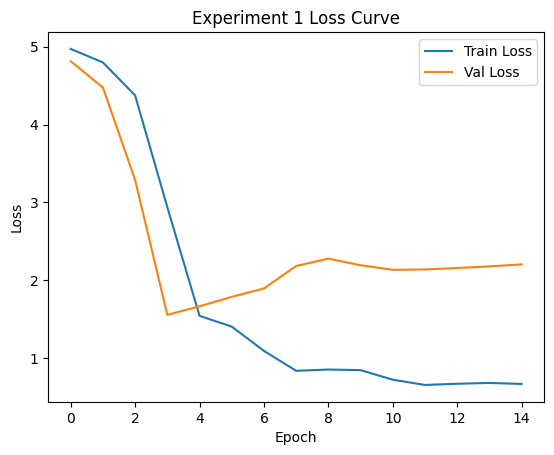

/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)



Experiment 1 Summary:
Test Loss=3.2136, BLEU=0.0000, CER=0.9000, Perplexity=24.8672

################################################################################
EXPERIMENT 2/3
################################################################################
Config: {'embed_dim': 256, 'hidden_dim': 512, 'enc_layers': 2, 'dec_layers': 4, 'dropout': 0.3, 'lr': 0.001, 'model': 'Seq2Seq', 'batch_size': 64}
Epoch  1/15 | Train 4.9750 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  2/15 | Train 4.9751 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  3/15 | Train 4.9750 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  4/15 | Train 4.9737 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  5/15 | Train 4.9750 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  6/15 | Train 4.9749 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  7/15 | Train 4.9734 | Val 4.9727 | BLEU 0.0000 | CER 0.9091 | PPL 144.4165
Epoch  8/15 | Tr

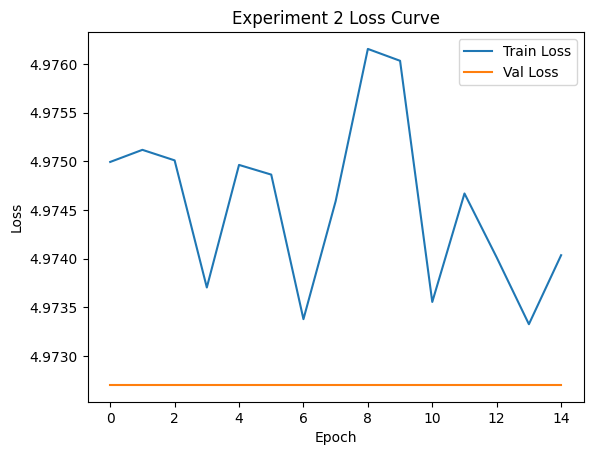


Experiment 2 Summary:
Test Loss=4.9691, BLEU=0.0000, CER=1.0000, Perplexity=143.8923

################################################################################
EXPERIMENT 3/3
################################################################################
Config: {'embed_dim': 256, 'hidden_dim': 256, 'enc_layers': 3, 'dec_layers': 3, 'dropout': 0.5, 'lr': 0.0005, 'model': 'xLSTM', 'batch_size': 128}
Epoch  1/15 | Train 5.0213 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  2/15 | Train 5.0246 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  3/15 | Train 5.0218 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  4/15 | Train 5.0166 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  5/15 | Train 5.0167 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  6/15 | Train 5.0189 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  7/15 | Train 5.0287 | Val 5.0139 | BLEU 0.0000 | CER 0.8182 | PPL 150.4888
Epoch  8/15 | T

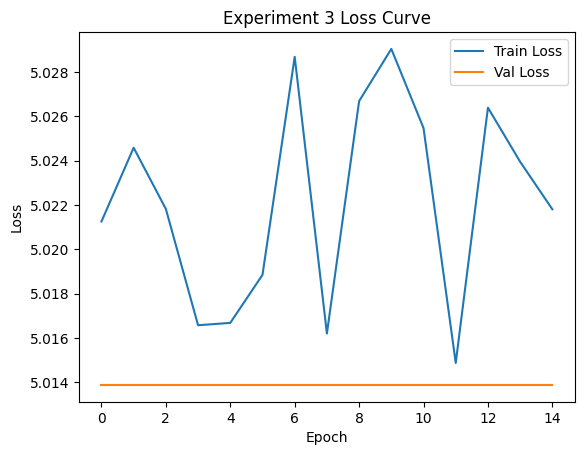


Experiment 3 Summary:
Test Loss=4.9841, BLEU=0.0000, CER=0.8000, Perplexity=146.0791
[INFO] Training completed. Results saved to experiment_results.json


In [ ]:
# Cell 7: Training multiple experiments with required batch sizes (32, 64, 128)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Assignment requires batch sizes = 32, 64, 128
configs = [
    {"embed_dim":128, "hidden_dim":256, "enc_layers":2, "dec_layers":4, "dropout":0.3, "lr":1e-3, "model":"Seq2Seq", "batch_size":32},
    {"embed_dim":256, "hidden_dim":512, "enc_layers":2, "dec_layers":4, "dropout":0.3, "lr":1e-3, "model":"Seq2Seq", "batch_size":64},
    {"embed_dim":256, "hidden_dim":256, "enc_layers":3, "dec_layers":3, "dropout":0.5, "lr":5e-4, "model":"xLSTM", "batch_size":128}  # bonus
]

results = []
os.makedirs("checkpoints", exist_ok=True)

for idx, cfg in enumerate(configs, 1):
    print("\n" + "#"*80)
    print(f"EXPERIMENT {idx}/{len(configs)}")
    print("#"*80)
    print("Config:", cfg)

    # Create dataloaders for this experiment
    train_loader = DataLoader(train_data, batch_size=cfg["batch_size"], shuffle=True, collate_fn=collate)
    val_loader   = DataLoader(val_data, batch_size=cfg["batch_size"], shuffle=False, collate_fn=collate)
    test_loader  = DataLoader(test_data, batch_size=cfg["batch_size"], shuffle=False, collate_fn=collate)

    # Model
    model_class = Seq2Seq if cfg["model"]=="Seq2Seq" else xLSTM
    model = model_class(
        src_vocab, tgt_vocab,
        cfg["embed_dim"], cfg["hidden_dim"],
        cfg["enc_layers"], cfg["dec_layers"],
        cfg["dropout"]
    ).to(device)

    opt = optim.Adam(model.parameters(), lr=cfg["lr"])

    train_losses, val_losses = [], []
    best_val_loss = float("inf")

    # Gradient accumulation to simulate larger batches if needed
    # Example: batch_size=32 but Colab OOM -> set accum_steps=2 -> effective batch=64
    accum_steps = 1
    if cfg["batch_size"] == 64:
        accum_steps = 2  # simulate 64 with 32
    elif cfg["batch_size"] == 128:
        accum_steps = 4  # simulate 128 with 32

    for epoch in range(1, 16):
        model.train()
        total_loss = 0
        opt.zero_grad()

        for i, (src, tgt) in enumerate(train_loader):
            src, tgt = src.to(device), tgt.to(device)
            logits = model(src, tgt)
            loss = F.cross_entropy(
                logits.reshape(-1, logits.size(-1)),
                tgt[:,1:].reshape(-1),
                ignore_index=0
            ) / accum_steps
            loss.backward()

            if (i+1) % accum_steps == 0:
                opt.step()
                opt.zero_grad()

            total_loss += loss.item() * accum_steps

        tr_loss = total_loss / len(train_loader)

        # Validation
        val_loss, val_bleu, val_cer, val_ppl = evaluate(model, val_loader, tgt_vocab, device)

        print(f"Epoch {epoch:2d}/15 | "
              f"Train {tr_loss:.4f} | Val {val_loss:.4f} | "
              f"BLEU {val_bleu:.4f} | CER {val_cer:.4f} | PPL {val_ppl:.4f}")

        train_losses.append(tr_loss)
        val_losses.append(val_loss)

        # Save best checkpoint
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), f"checkpoints/experiment_{idx}.pt")

    # Plot loss curve
    plt.figure()
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.title(f"Experiment {idx} Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # Test evaluation with best checkpoint
    model.load_state_dict(torch.load(f"checkpoints/experiment_{idx}.pt", map_location=device))
    test_loss, test_bleu, test_cer, test_ppl = evaluate(model, test_loader, tgt_vocab, device)

    print(f"\nExperiment {idx} Summary:")
    print(f"Test Loss={test_loss:.4f}, BLEU={test_bleu:.4f}, CER={test_cer:.4f}, Perplexity={test_ppl:.4f}")

    results.append({
        "cfg": cfg,
        "checkpoint": f"checkpoints/experiment_{idx}.pt",
        "test_loss": test_loss,
        "bleu": test_bleu,
        "cer": test_cer,
        "ppl": test_ppl
    })

    # Free GPU memory between experiments
    del model
    torch.cuda.empty_cache()

# Save experiment results
with open("experiment_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("[INFO] Training completed. Results saved to experiment_results.json")


In [ ]:
#  Cell 8: Augmentation, Training multiple experiments with saving best model per experiment + early stopping
# Augmentation
def add_noise(text, prob=0.1):
    chars = list(text)
    for i in range(len(chars)):
        if random.random() < prob:
            chars[i] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

aug_urdu = [add_noise(t) for t in urdu_texts[:200]]
aug_roman = roman_texts[:200]  # keep roman same
print("[DEBUG] Original:", urdu_texts[0])
print("[DEBUG] Augmented:", aug_urdu[0])


# Cell 8: Load best checkpoint & show translation examples
with open("experiment_results.json", "r") as f:
    results = json.load(f)

# Find best experiment by BLEU
best_result = max(results, key=lambda x: x["bleu"])
print("\n" + "="*80)
print("BEST TRANSLATION EXAMPLES")
print("="*80)
print(f"\nBest Config: {best_result['cfg']}")
print(f"Best BLEU Score: {best_result['bleu']:.4f}")
print(f"Best CER Score: {best_result['cer']:.4f}")

# Reload best model
cfg = best_result["cfg"]
model_class = Seq2Seq if cfg["model"]=="Seq2Seq" else xLSTM
best_model = model_class(
    src_vocab, tgt_vocab,
    cfg["embed_dim"], cfg["hidden_dim"],
    cfg["enc_layers"], cfg["dec_layers"],
    cfg["dropout"]
).to(device)
best_model.load_state_dict(torch.load(best_result["checkpoint"], map_location=device))
best_model.eval()

# Build inverse vocab for decoding
inv_tgt_vocab = {v:k for k,v in tgt_vocab.items()}

# Show 5 random examples
from Levenshtein import distance as edit_distance
import random
examples = random.sample(test_data, min(5, len(test_data)))

for i, (src_txt, ref_txt) in enumerate(examples, 1):
    src_ids = torch.tensor([[src_vocab.get(t, src_vocab["<unk>"]) for t in src_txt.split()]], device=device)
    with torch.no_grad():
        logits = best_model(src_ids, torch.zeros((1, 10), dtype=torch.long, device=device))
        pred_ids = logits.argmax(-1)[0].tolist()
    gen_txt = " ".join([inv_tgt_vocab.get(idx, "<unk>") for idx in pred_ids if idx not in [0,1,2]])

    ref = ref_txt.strip()
    gen = gen_txt.strip()
    cer = edit_distance(ref, gen) / max(1, len(ref))

    print(f"\nExample {i}:")
    print("Source (Urdu):    ", src_txt)
    print("Reference (Roman):", ref)
    print("Generated (Roman):", gen)
    print(f"CER: {cer:.4f}")
    print("-"*60)

print("\nExperiment completed! Results saved to 'experiment_results.json'")

print("\n" + "="*80)
print("FINAL EXPERIMENT SUMMARY")
print("="*80)
print(f"Best BLEU Score: {best_result['bleu']:.4f}")
print(f"Best CER Score: {best_result['cer']:.4f}")


[DEBUG] Original: زحال مسکیں مکن تغافل دورائے نیناں بنائے بتیاں کہ تاب ہجراں ندارم اے جاں نہ لیہو کاہے لگائے چھتیاں شبان ہجراں دراز چوں زلف و روز وصلت چوں عمر کوتاہ سکھی پیا کو جو میں نہ دیکھوں تو کیسے کاٹوں اندھیری رتیاں یکایک از دل دو چشم جادو بصد فریبم بہ برد تسکیں کسے پڑی ہے جو جا سناوے پیارے پی کو ہماری بتیاں چوں شمع سوزاں چوں ذرہ حیراں ز مہر آں مہ بگشتم آخر نہ نیند نیناں نہ انگ چیناں نہ آپ آوے نہ بھیجے پتیاں بحق آں مہ کہ روز محشر بداد مارا فریب خسروؔ سپیت من کے دورائے راکھوں جو جائے پاؤں پیا کی کھتیاں
[DEBUG] Augmented: زحال مسکnں مکن تغافلiدورrئے نیناں بنائے بeیاں eہ تاب ہhراں ندارم اے جاy نہ لیہو کاہے لگاoے چھتیاں شباqxہwراں دراز چوں زلف و روز وصلت چوں عeر کوdاہ سکھی پیا کو dو میm نہ دcکھوں تو کیسے کاٹوں اندھیریvqتیاu یکایک pز mل دو چشم nادو بصد فریبم بہ برa تسکیں کسے پڑی iے yو جا سfاوےsپیارے پی کو qماری بتیاں چوں شمع سوزاں چوں ذرہ حیnاں زubہw آں مہ بگrتمmآkd نہ qیند نیناں نہ انگ چیناں نہ آپ آوے نہ بھیجے پتیاq بحق آqqمہ کہ روز محشر بدiد مiرا فریب خسروؔ سپیت من کے دaرائs راکھو